PS 1

1.

If I have total investments worth less than the total capital I have, than that is called leverage less than 1. For example, If I buy shares of 1000 rupees and I have total 5000 rupees, I have leverage of 0.2.

It can make sense when the trader doesn't want to take much risk. So, he/she invests less than the total capital available.

In backtesting engine, trades can use this to check how their trade would have performed in the past.

2.

Static stop loss can be said to be defined as a fix number which is fixed at the start of the trade , if the market hits the values the position is automatically closed and losses are minimised in this form.

For a dynamic stop loss, it is set as a %age or some fixed price above or below the highest price reached in the market. If the value of share reversed by trailing amount, the position is automatically closed.

In a trending market , static stop loss can exit abruptly, thereby missing profits due to shifting trends. But dynamic stop loss will go with the trend and lock in profits.

In a volatile market, both can perform poorly as  stoploss could be hit and the static stoploss will close the trade, thereby exiting the market. Also, dynamic stop loss need a bigger %age or amount difference to lock in profits.


3.


Trailing take profit is not always necessary. But it can help increase the profits. If a trader uses this strategy, the trade will be closed when the price fall to a certain threshold below peak price. This can make more profits than a fixed value.

This is also done by another risk management technique called trailing stop loss. Both are similar in working.

4.

1. If the price falls abruptly forming a gap, so the price falls below stoploss. In this case the trade can remain open.


PS. 2

In [1]:
pip install yfinance pandas ta


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=6f2226fa0d563d73fea86116bc08015e67b96b731889f62f3004ee53f4a463bf
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [2]:
pip install yfinance mplfinance pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 4.8 MB/s eta 0:00:00


<ipython-input-3-2266110613>:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("RELIANCE.NS", period="5y", interval="1d")
[*********************100%***********************]  1 of 1 completed


Doji: 64/129 profitable days -> Win rate: 49.61%
Hammer: 13/29 profitable days -> Win rate: 44.83%
Engulfing: 16/30 profitable days -> Win rate: 53.33%
Random Baseline Win Rate: 60.47%

📈 Showing 5 examples of Doji patterns...


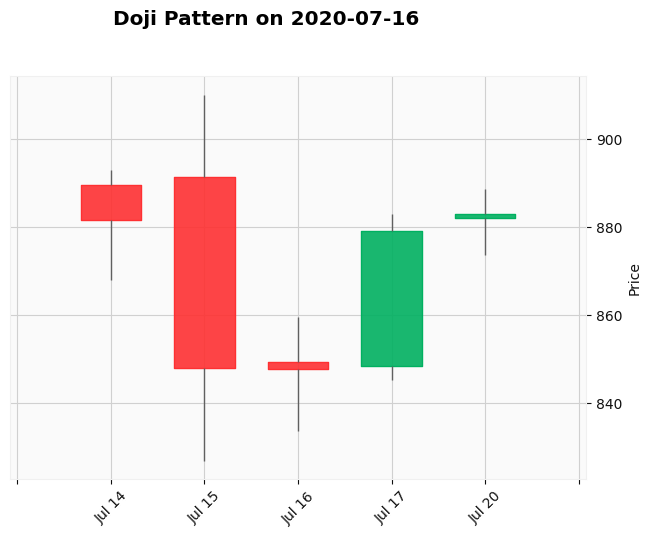

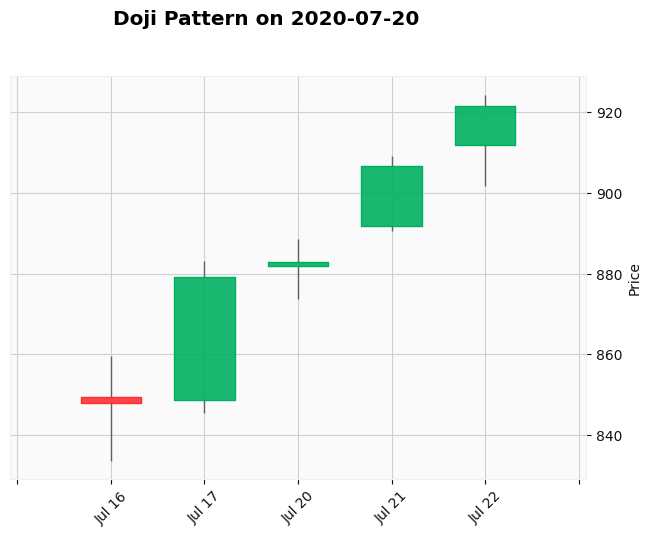

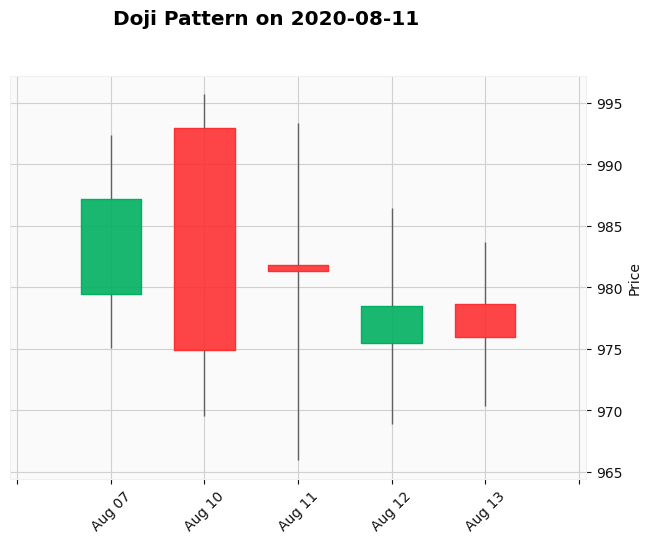

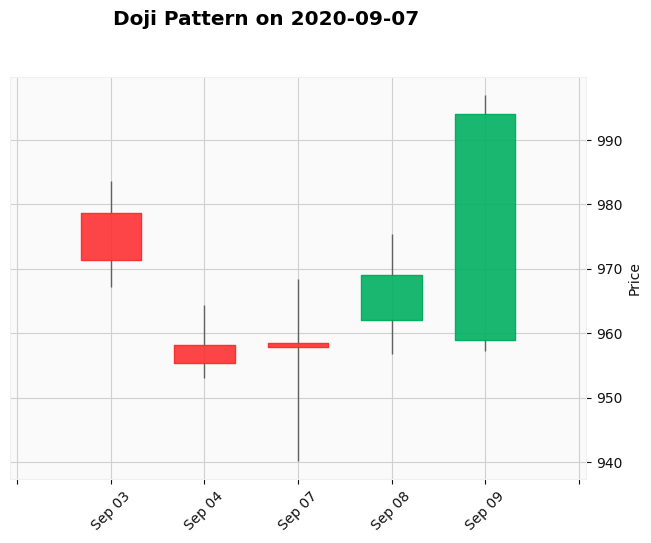

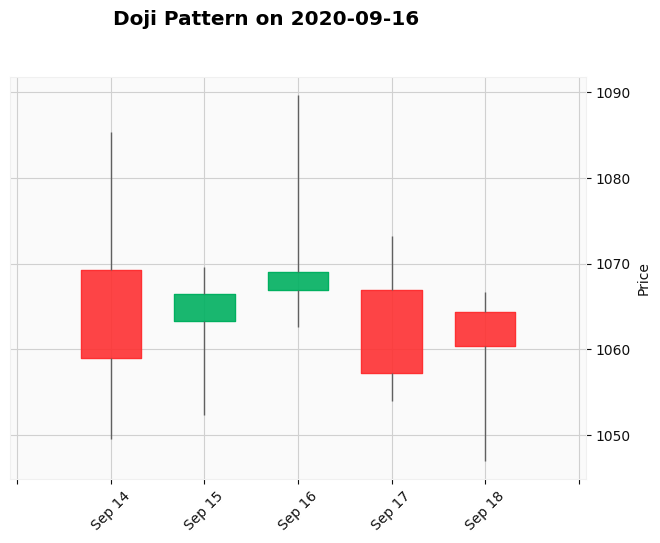


📈 Showing 5 examples of Hammer patterns...


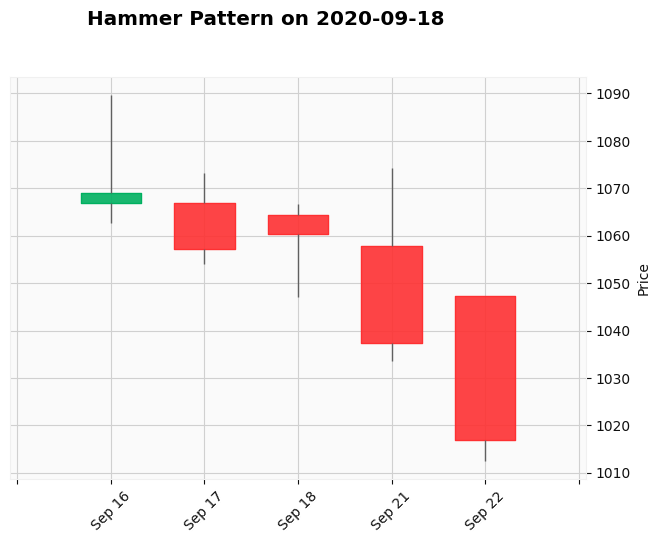

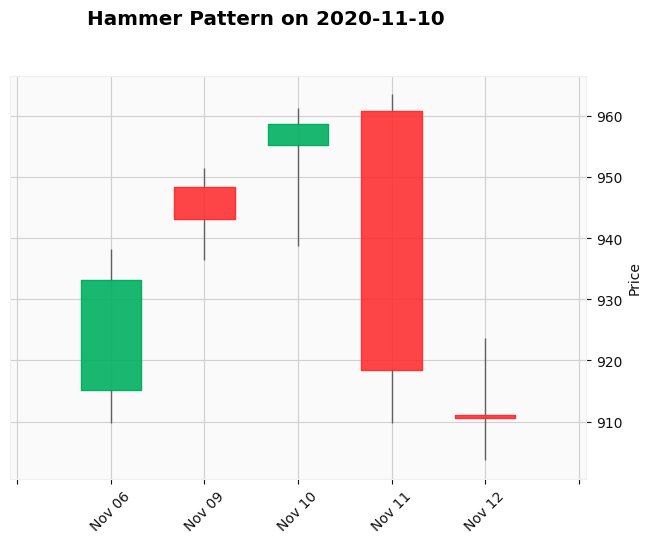

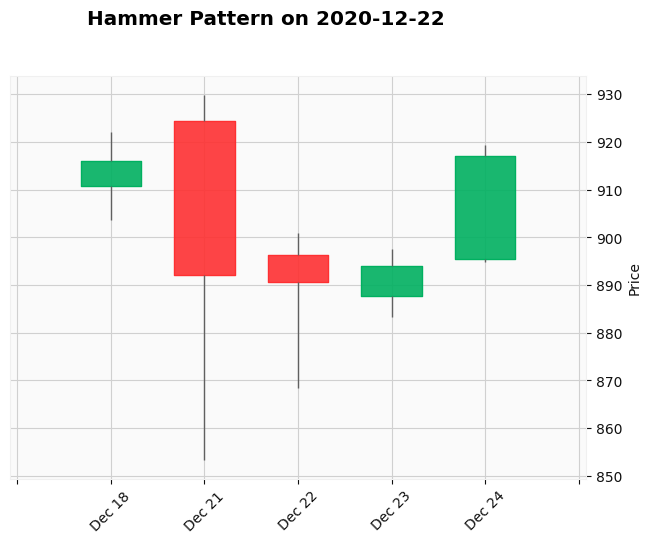

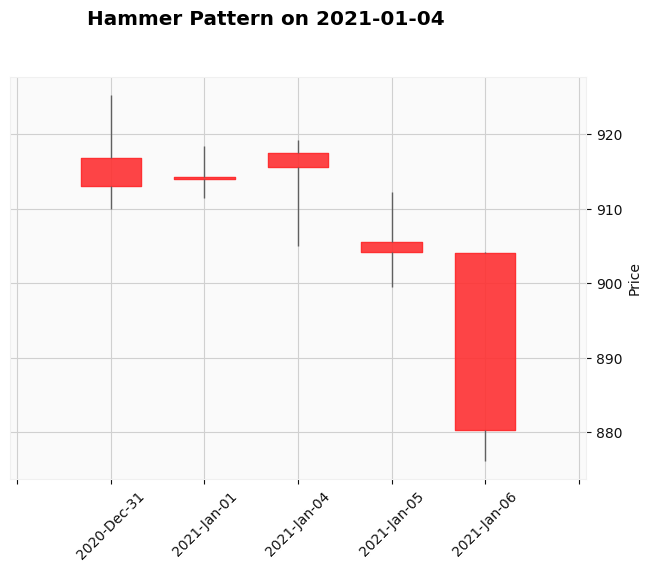

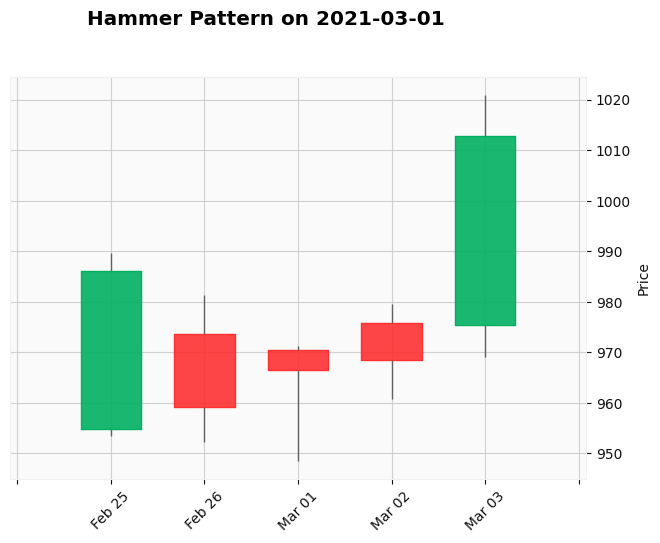


📈 Showing 5 examples of Engulfing patterns...


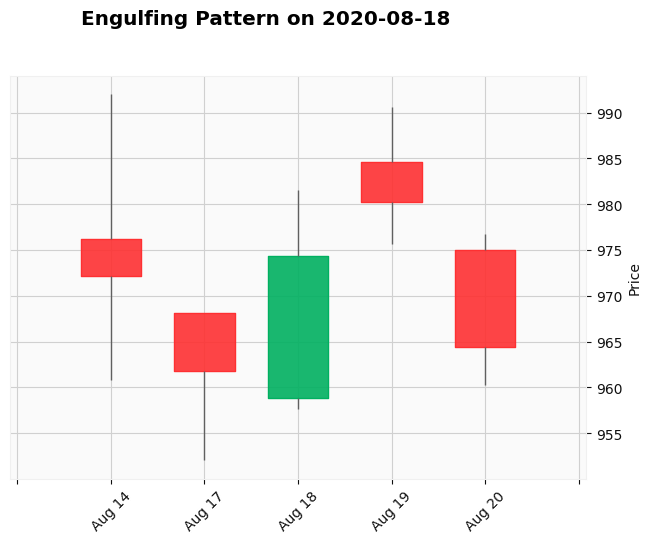

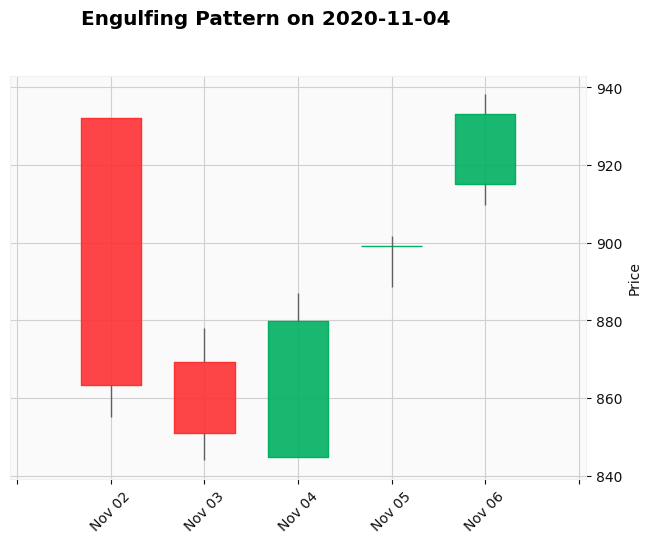

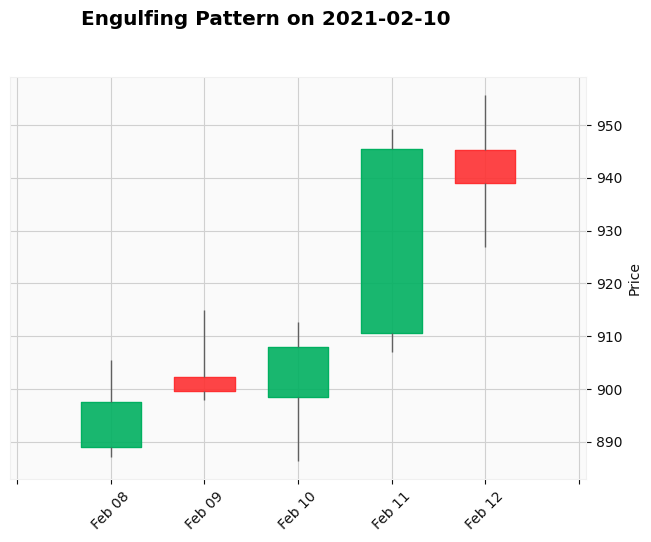

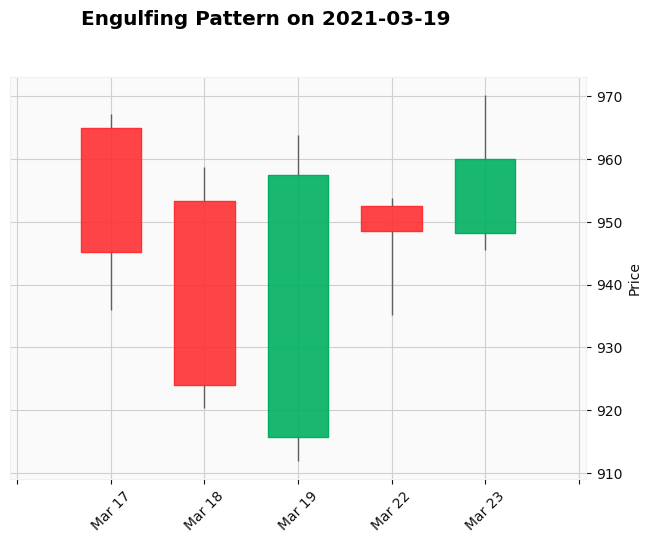

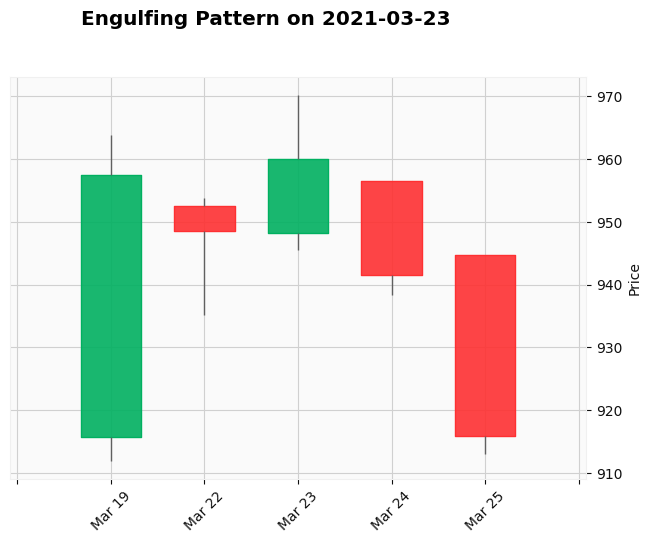

In [3]:
import yfinance as yf
import pandas as pd
import mplfinance as mpf
import numpy as np

# Download 5 years of historical data for an NSE stock (e.g., RELIANCE.NS)
df = yf.download("RELIANCE.NS", period="5y", interval="1d")
df.dropna(inplace=True)

# Flatten the column names
df.columns = ['_'.join(col).strip() for col in df.columns.values]

# Helper: Add next day's return to analyze profitability
df['Next_Close'] = df['Close_RELIANCE.NS'].shift(-1)
df['Next_Return'] = (df['Next_Close'] - df['Close_RELIANCE.NS']) / df['Close_RELIANCE.NS']

# Define Doji: open and close are very close
def is_doji(row, threshold=0.1):
    return abs(row['Open_RELIANCE.NS'] - row['Close_RELIANCE.NS']) <= threshold * (row['High_RELIANCE.NS'] - row['Low_RELIANCE.NS'])

# Define Hammer: small body, long lower wick
def is_hammer(row):
    body = abs(row['Open_RELIANCE.NS'] - row['Close_RELIANCE.NS'])
    lower_wick = min(row['Open_RELIANCE.NS'], row['Close_RELIANCE.NS']) - row['Low_RELIANCE.NS']
    upper_wick = row['High_RELIANCE.NS'] - max(row['Open_RELIANCE.NS'], row['Close_RELIANCE.NS'])
    return lower_wick > 2 * body and upper_wick < body

# Define Bullish Engulfing: red candle followed by green that engulfs previous
def is_bullish_engulfing(i):
    if i == 0:
        return False
    prev = df.iloc[i - 1]
    curr = df.iloc[i]
    return (prev['Close_RELIANCE.NS'] < prev['Open_RELIANCE.NS'] and
            curr['Close_RELIANCE.NS'] > curr['Open_RELIANCE.NS'] and
            curr['Close_RELIANCE.NS'] > prev['Open_RELIANCE.NS'] and
            curr['Open_RELIANCE.NS'] < prev['Close_RELIANCE.NS'])

# Detect patterns
df['Doji'] = df.apply(is_doji, axis=1)
df['Hammer'] = df.apply(is_hammer, axis=1)
df['Engulfing'] = [is_bullish_engulfing(i) for i in range(len(df))]

# Analyze win rates (Next_Return > 0 means profit)
def win_rate(pattern):
    mask = df[pattern]
    wins = df.loc[mask, 'Next_Return'] > 0
    return wins.sum(), len(wins), wins.sum() / len(wins) * 100 if len(wins) else 0

for pattern in ['Doji', 'Hammer', 'Engulfing']:
    wins, total, rate = win_rate(pattern)
    print(f"{pattern}: {wins}/{total} profitable days -> Win rate: {rate:.2f}%")

# Optional: baseline random entry
np.random.seed(42)
random_entries = df.sample(n=len(df[df['Doji']]), random_state=42)
random_winrate = (random_entries['Next_Return'] > 0).mean() * 100
print(f"Random Baseline Win Rate: {random_winrate:.2f}%")




#####
#####
# Helper function to plot a few examples of a pattern
def plot_pattern(df, pattern_name, num_charts=5):
    print(f"\n📈 Showing {num_charts} examples of {pattern_name} patterns...")
    pattern_dates = df.index[df[pattern_name]].tolist()

    for i in range(min(num_charts, len(pattern_dates))):
        date = pattern_dates[i]
        try:
            start_index = df.index.get_loc(date) - 2  # 2 days before the pattern
            end_index = df.index.get_loc(date) + 2   # 2 days after the pattern
            if start_index < 0: start_index = 0
            if end_index >= len(df): end_index = len(df) - 1

            start = df.index[start_index]
            end = df.index[end_index]

            plot_df = df.loc[start:end].copy()

            # Rename columns for mplfinance
            plot_df.columns = ['Close', 'High', 'Low', 'Open', 'Volume', 'Next_Close', 'Next_Return', 'Doji', 'Hammer', 'Engulfing']

            if len(plot_df) >= 5:  # ensure enough data around
                mpf.plot(
                    plot_df[['Open', 'High', 'Low', 'Close', 'Volume']], # Select OHLCV columns
                    type='candle',
                    title=f'{pattern_name} Pattern on {date.strftime("%Y-%m-%d")}',
                    ylabel='Price',
                    style='yahoo'
                )
        except Exception as e:
            print(f"Could not plot pattern on {date.strftime('%Y-%m-%d')}: {e}")

# Example: Show plots for each pattern
plot_pattern(df, 'Doji')
plot_pattern(df, 'Hammer')
plot_pattern(df, 'Engulfing')




PS 2

In [20]:
def download_flat_yf(ticker, start, end, interval):
    data = yf.download(ticker, start=start, end=end, interval=interval, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, axis=1, level=1)

    data.columns.name = None
    data.reset_index(inplace=True)
    data.columns = [col.lower() for col in data.columns]
    if data.columns[0] in ['date', 'datetime']:
        data.rename(columns={data.columns[0]: 'datetime'}, inplace=True)
    data.loc[:,'datetime'] = pd.to_datetime(data['datetime'])

    return data

stock_symbol = 'RELIANCE.NS'
data = download_flat_yf(stock_symbol, start='2020-06-01', end='2025-06-01', interval='1d')
data.head()

<ipython-input-20-4173792679>:2: FutureWarning:

YF.download() has changed argument auto_adjust default to True



,datetime,close,high,low,open,volume
0,2020-06-01,699.203735,707.481883,678.784321,680.646907,39943702
1,2020-06-02,706.263062,708.240664,699.410608,701.802112,22153960
2,2020-06-03,708.999512,717.438597,705.182314,710.540161,25381289
3,2020-06-04,726.544556,731.005566,708.700575,710.080226,34202350
4,2020-06-05,727.418335,744.112576,723.739145,733.534950,33076685


In [21]:
import plotly.graph_objects as go
fig = go.Figure(data=[
    go.Candlestick(x=data.index,
                   open=data['open'],
                   high=data['high'],
                   low=data['low'],
                   close=data['close'])
              ])
fig.update_layout(title=f"Candlestick Chart - {stock_symbol}", xaxis_title='Date', yaxis_title='Price')
fig.show()

In [22]:
def hammer(open_, high, low, close):
    body = abs(close - open_)
    lower_wick = min(open_, close) - low
    upper_wick = high - max(open_, close)
    return (
        body < (high - low) * 0.3 and
        lower_wick > body * 2 and
        upper_wick < body
    )

data['hammer'] = data.apply(lambda row: hammer(row['open'], row['high'], row['low'], row['close']), axis=1)
def dogi(open_,high,low,close):
    body = abs(close - open_)
    lower_wick = min(open_, close) - low
    upper_wick = high - max(open_, close)
    return (
        0.001<body and
        body<0.1
    )
data['dogi'] = data.apply(lambda row: dogi(row['open'], row['high'], row['low'], row['close']), axis=1)
def is_bullish_engulfing(prev, curr):
    return (
        prev['close'] < prev['open'] and
        curr['close'] > curr['open'] and
        curr['open'] < prev['close'] and
        curr['close'] > prev['open']
    )

def is_bearish_engulfing(prev, curr):
    return (
        prev['close'] > prev['open'] and
        curr['close'] < curr['open'] and
        curr['open'] > prev['close'] and
        curr['close'] < prev['open']
    )

In [23]:
hammer_dates = data[data['hammer']].index
hammer_prices = data[data['hammer']]['close']
dogi_dates = data[data['dogi']].index
dogi_prices = data[data['dogi']]['close']
data['bullish_engulfing'] = False
data['bearish_engulfing'] = False

for i in range(1, len(data)):
    prev = data.iloc[i - 1]
    curr = data.iloc[i]
    data.at[data.index[i], 'bullish_engulfing'] = is_bullish_engulfing(prev, curr)
    data.at[data.index[i], 'bearish_engulfing'] = is_bearish_engulfing(prev, curr)

In [24]:
bullish = data[data['bullish_engulfing']]
bearish = data[data['bearish_engulfing']]
fig = go.Figure(data=[
    go.Candlestick(x=data.index,
                   open=data['open'],
                   high=data['high'],
                   low=data['low'],
                   close=data['close'])
              ,
    go.Scatter(x=hammer_dates, y=hammer_prices, mode='markers', marker=dict(color='red', size=5), name='Hammer'),
    go.Scatter(x=dogi_dates, y=dogi_prices, mode='markers', marker=dict(color='green', size=5), name='Dogi'),
    go.Scatter(x=bullish.index, y=bullish['close'], mode='markers', marker=dict(color='blue', size=5), name='Bullish Engulfing'),
    go.Scatter(x=bearish.index, y=bearish['close'], mode='markers', marker=dict(color='orange', size=5), name='Bearish Engulfing')

    ])
fig.update_layout(title=f"Candlestick Chart - {stock_symbol}", xaxis_title='Date', yaxis_title='Price')
fig.show()

In [25]:
def Win_rate(n,data,pattern):
  wins = 0
  total = 0
  for i in range(len(data) - n):
      if data[pattern].iloc[i]:
          current_close = data['close'].iloc[i]
          close_n = data['close'].iloc[i+n]

          if close_n > current_close:
              wins += 1
          total += 1
  # Final win rate
  win_rate = wins / total if total > 0 else 0
  return win_rate

In [26]:
dogi_winrate_3= Win_rate(3,data,'dogi')
print(f"Dogi Win Rate n = 3: {dogi_winrate_3*100}")
hammer_winrate_3 = Win_rate(3,data,'hammer')
print(f"Hammer Win Rate n = 3: {hammer_winrate_3*100}")
bullish_winrate_3 = Win_rate(3,data,'bullish_engulfing')
print(f"Bullish Win Rate n = 3: {bullish_winrate_3*100}")
bearish_winrate_3 = Win_rate(3,data,'bearish_engulfing')
print(f"Bearish Win Rate for n = 3: {bearish_winrate_3*100}")
dogi_winrate = Win_rate(5,data,'dogi')
print(f"Dogi Win Rate n = 5: {dogi_winrate*100}")
hammer_winrate = Win_rate(5,data,'hammer')
print(f"Hammer Win Rate n = 5: {hammer_winrate*100}")
bullish_winrate = Win_rate(5,data,'bullish_engulfing')
print(f"Bullish Win Rate n = 5: {bullish_winrate*100}")
bearish_winrate = Win_rate(5,data,'bearish_engulfing')
print(f"Bearish Win Rate for n = 5: {bearish_winrate*100}")

Dogi Win Rate n = 3: 41.66666666666667
Hammer Win Rate n = 3: 48.275862068965516
Bullish Win Rate n = 3: 48.38709677419355
Bearish Win Rate for n = 3: 53.96825396825397
Dogi Win Rate n = 5: 41.66666666666667
Hammer Win Rate n = 5: 55.172413793103445
Bullish Win Rate n = 5: 45.16129032258064
Bearish Win Rate for n = 5: 50.79365079365079


In [27]:
def baseline_win_rate( df, n,pattern):
    indices = data.index
    pattern_indices = data.index[data[pattern]=='True']
    M_indices= len(pattern_indices)
    valid_random_pool = np.setdiff1d(np.arange(len(data) - 3),indices)
    random_indices = np.random.choice(valid_random_pool, size=M_indices, replace=False)
    valid = [idx for idx in indices if idx + n < len(df)]
    wins = sum(data['close'].iloc[idx + n] > data['close'].iloc[idx] for idx in valid)
    return wins / len(valid) if valid else 0

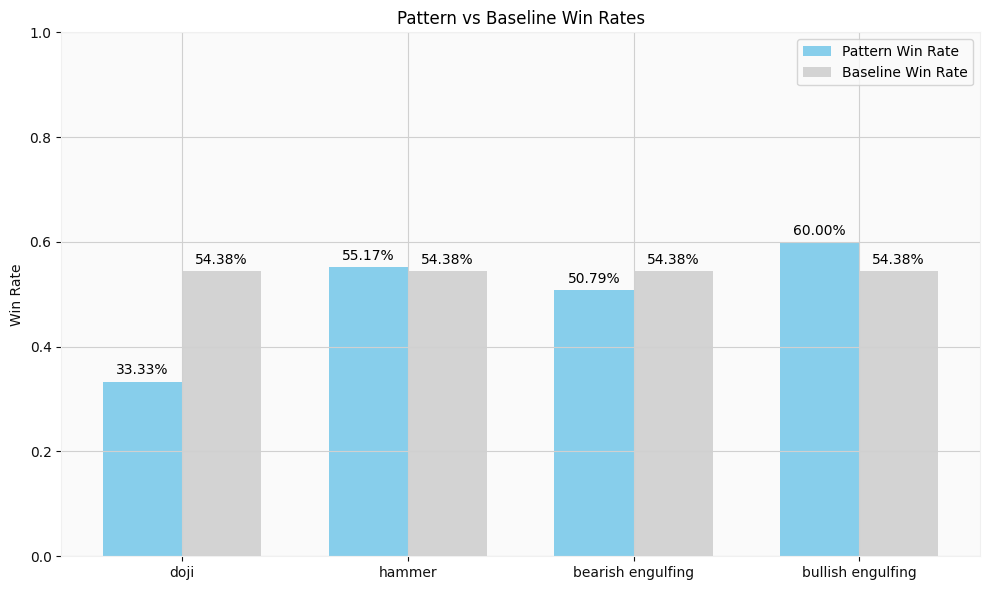

In [28]:
import matplotlib.pyplot as plt
import numpy as np
n = 6
# Compute actual win rates (call your functions here)
dogi_winrate_3 = Win_rate( n,data, 'dogi')                 # <-- You must have this function
hammer_winrate_3 = Win_rate( n,data, 'hammer')
bearish_winrate_3 = Win_rate( n, data,'bearish_engulfing')
bullish_winrate_3 =Win_rate( n,data, 'bullish_engulfing')

# Compute baselines (call function!)
base_line_dogi = baseline_win_rate(data, n, 'dogi')
base_line_hammer = baseline_win_rate(data, n, 'hammer')
base_line_bear = baseline_win_rate(data, n, 'bearish_engulfing')
base_line_bull = baseline_win_rate(data, n, 'bullish_engulfing')

# Labels and data
patterns = ['doji', 'hammer', 'bearish engulfing', 'bullish engulfing']
pattern_win_rates = [dogi_winrate_3, hammer_winrate_3, bearish_winrate_3, bullish_winrate_3]
baseline_win_rates = [base_line_dogi, base_line_hammer, base_line_bear, base_line_bull]

# Plotting
x = np.arange(len(patterns))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, pattern_win_rates, width, label='Pattern Win Rate', color='skyblue')
bars2 = ax.bar(x + width/2, baseline_win_rates, width, label='Baseline Win Rate', color='lightgray')

# Axis labeling and ticks
ax.set_ylabel('Win Rate')
ax.set_title('Pattern vs Baseline Win Rates')
ax.set_xticks(x)
ax.set_xticklabels(patterns)
ax.set_ylim(0, 1)
ax.legend()

# Annotate bars with % values
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2%}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

1. Baseline performs better than Doji and bearish engulfing. Performs poorly in hammer and bullish engulfing.
2. At n=5 it outperforms
3.bullish engulfing is the most consistent pattern.

PS 3

Q1

1. In the first green line, there are a few spinning tops. It is preceded with a few engulfing pattern, it means the market is witnessing bull entry.
2. The red line is witnessing a bearish engulfing.
3. The next green arrows shows the market is being at the same price but the market starts to rise, so we can enter the market.


Q2
Supertrend and MFI are 2 important indicators


Q3


MFI tells us that at first the stock is near 20 so it will increase and later at 80 the price is likely to decrease.

2

Q1

1. For long position, we need to check for a bullish pattern near the support line and bearish pattern at the resistance line.
2. For short position, sell near the resistance line checking for a bearish pattern, then buy at the support line checking a bullish pattern

Q2
Moving average can be good rule of variants and using ADX can be good choice

3

In [29]:
stock_symbol = 'CAMS.NS'
data = download_flat_yf(stock_symbol, start='2020-06-01', end='2025-06-01', interval='1d')
data.head()

<ipython-input-20-4173792679>:2: FutureWarning:

YF.download() has changed argument auto_adjust default to True



,datetime,close,high,low,open,volume
0,2020-10-05,1301.218750,1382.556504,1272.991919,1318.489077,638095
1,2020-10-06,1317.932129,1338.777212,1301.079586,1309.204079,542573
2,2020-10-07,1282.695068,1321.878410,1258.832314,1319.417827,283115
3,2020-10-08,1239.472900,1290.587509,1230.466250,1285.991412,287027
4,2020-10-09,1241.236938,1273.177713,1202.425027,1231.301776,617512


Backtest Engine

In [30]:
#@title Backtest Engine
def perform_backtest(dataframe, lev=1, initial_capital=100000 , lot_size=1, tsl=100):
    """
    Backtesting engine for trading strategies.

    Parameters:
    - dataframe: Pandas DataFrame with columns ['timestamp', 'close', 'high', 'signals']
                 signals: 1 for long entry/close short, -1 for short entry/close long, 0 no action
    - lev: Leverage multiplier for position sizing (default 1)
    - initial_capital: Starting capital for backtest (default 100000)
    - lot_size: Number of units per lot (default 1)
    - tsl: Trailing stop loss percentage (default 100%)

    Returns:
    - trade_log: DataFrame summarizing all trades with entry/exit dates, profit/loss, size and type
    """
    capital_list = [initial_capital]
    trade = 0  # 0 = no open trade, 1 = long trade open, -1 = short trade open
    position_size = 0
    trade_profit = []
    entry, exit = [], []
    entry_index, exit_index = [], []
    nol, nos = 0, 0  # Number of long and short trades
    long_profit, short_profit = [], []
    trade_type = []
    position_size_list = []

    # Calculate benchmark returns over entire backtest period
    benchmark_returns = (dataframe.loc[dataframe.index[-1], 'close'] / dataframe.loc[dataframe.index[0], 'close'] - 1) * 100

    # Calculate backtest period in years and months
    backtest_period = dataframe.loc[dataframe.index[-1], 'timestamp'] - dataframe.loc[dataframe.index[0], 'timestamp']
    total_days = backtest_period.days
    years = total_days // 365
    remaining_days = total_days % 365
    months = remaining_days // 30

    max_price = 0  # For tracking trailing stop price

    for i in range(len(dataframe)):
        date = dataframe.loc[i, 'timestamp']
        current_price = dataframe.loc[i, 'close']
        high_price = dataframe.loc[i, 'high']

        # Stop if capital is exhausted
        if capital_list[-1] <= 0:
            print(f'Complete capital lost on {date}')
            break

        # Open Long trade if no trade is open and signal is long (1)
        if trade == 0 and dataframe.loc[i, 'signals'] == 1:
            position_size = (capital_list[-1] * lev) // (current_price * lot_size)
            cost = position_size * current_price * lot_size
            if cost > 0:
                position_size_list.append(position_size * lot_size)
                trade = 1
                entry.append(date)
                entry_index.append(i)
                max_price = current_price  # Initialize max price for trailing stop
            else:
                position_size = 0

        # Open Short trade if no trade is open and signal is short (-1)
        elif trade == 0 and dataframe.loc[i, 'signals'] == -1:
            position_size = (capital_list[-1] * lev) // (current_price * lot_size)
            cost = position_size * current_price * lot_size
            if cost > 0:
                position_size_list.append(position_size * lot_size)
                trade = -1
                entry.append(date)
                entry_index.append(i)
                max_price = current_price  # Initialize min price for trailing stop (will update below)
            else:
                position_size = 0

        # Manage open trade and trailing stop
        elif trade != 0:
            if trade == 1:
                # Update max price seen during long trade for trailing stop loss
                max_price = max(max_price, high_price)
                # Check if current close triggers trailing stop loss exit
                if dataframe.loc[i, 'close'] <= (1 - tsl / 100) * max_price:
                    # Set signal to close long and open short (or just close)
                    dataframe.loc[i, 'signals'] = -1  # force exit long
                    max_price = 0

            elif trade == -1:
                # For short, track minimum price for trailing stop loss
                max_price = min(max_price, high_price)
                # Check if current close triggers trailing stop loss exit
                if dataframe.loc[i, 'close'] >= (1 + tsl / 100) * max_price:
                    dataframe.loc[i, 'signals'] = 1  # force exit short
                    max_price = 0

            # If signal indicates closing current trade (opposite signal)
            if dataframe.loc[i, 'signals'] * trade == -1:
                exit.append(date)
                exit_index.append(i)
                if trade == 1:
                    nol += 1
                    profit = lot_size * current_price * position_size - cost
                else:
                    nos += 1
                    profit = cost - lot_size * current_price * position_size

                capital_list.append(capital_list[-1] + profit)
                trade_profit.append(profit)

                if trade == 1:
                    long_profit.append(profit)
                else:
                    short_profit.append(profit)

                trade_type.append('Long' if trade == 1 else 'Short')
                trade = 0
                position_size = 0
                cost = 0

    # Close any open trade at last price in dataframe
    if trade != 0:
        exit.append(dataframe.iloc[-1]['timestamp'])
        exit_index.append(len(dataframe) - 1)
        if trade == 1:
            nol += 1
            profit = dataframe.iloc[-1]['close'] * position_size * lot_size - cost
            trade_type.append('Long')
        else:
            nos += 1
            profit = cost - dataframe.iloc[-1]['close'] * position_size * lot_size
            trade_type.append('Short')
        capital_list.append(capital_list[-1] + profit)
        trade_profit.append(profit)

    # Calculate returns for performance metrics
    returns = np.diff(capital_list) / capital_list[:-1]
    downside_returns = returns[returns < 0]

    sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252) if len(returns) > 0 and np.std(returns) > 0 else float('nan')
    sortino_ratio = np.mean(returns) / np.std(downside_returns) * np.sqrt(252) if len(downside_returns) > 0 and np.std(downside_returns) > 0 else float('nan')

    number_of_trades = len(trade_profit)

    capital_series = pd.Series(capital_list)
    running_max = capital_series.cummax()
    drawdowns = (capital_series - running_max) / running_max
    drawdowns = drawdowns[drawdowns <= 0]

    print(f'BACKTEST RESULTS:')
    if number_of_trades == 0:
        print('No trades taken')
        return

    print(f"Backtest Period: {years} years and {months} months")
    print(f'Benchmark Returns: {benchmark_returns * lev:.2f} %')
    print(f'Initial Capital: {capital_list[0]}')
    print(f'Final Capital: {capital_list[-1]:.2f}')
    print(f'Profit percentage: {(capital_list[-1] - capital_list[0]) / capital_list[0] * 100:.2f} %')
    print(f'Leverage applied: {lev}')
    print(f'Maximum Portfolio balance: {max(capital_list):.2f}')
    print(f'Minimum Portfolio balance: {min(capital_list):.2f}')
    print(f'Number of trades: {number_of_trades}')

    win = sum(1 for profit in trade_profit if profit > 0)
    print(f'Winning Trades: {win}')
    print(f'Losing Trades: {number_of_trades - win}')
    print(f'Win Rate: {win / number_of_trades * 100:.2f} %')

    try:
        avg_profit = statistics.mean([x for x in trade_profit if x > 0])
    except:
        avg_profit = 0
    try:
        avg_loss = statistics.mean([x for x in trade_profit if x <= 0])
    except:
        avg_loss = 0

    print(f'Average Profit: {avg_profit:.2f}')
    print(f'Average Loss: {avg_loss:.2f}')
    print(f'No of Long Trades: {nol}')
    print(f'No of Short Trades: {nos}')
    print(f'Average drawdown: {np.mean(drawdowns) * 100:.2f} %')
    print(f'Maximum drawdown: {np.min(drawdowns) * 100:.2f} %')
    print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
    print(f'Sortino Ratio: {sortino_ratio:.2f}')

    # Calculate and print holding times if any trades happened
    if entry and exit:
        holding_times = [(exit[i] - entry[i]) for i in range(len(entry))]
        max_holding_time = max(holding_times)
        days = max_holding_time.days
        hours, remainder = divmod(max_holding_time.seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        print(f'Maximum Holding Time: {days} days, {hours:02}:{minutes:02}:{seconds:02}')

        avg_holding_time = sum(holding_times, pd.Timedelta(0)) / len(holding_times)
        days_avg = avg_holding_time.days
        hours_avg, remainder_avg = divmod(avg_holding_time.seconds, 3600)
        minutes_avg, seconds_avg = divmod(remainder_avg, 60)
        print(f'Average Holding Time: {days_avg} days, {hours_avg:02}:{minutes_avg:02}:{seconds_avg:02}')

    # Plotting equity curve and price chart with entry/exit points
    fig = sp.make_subplots(
        rows=2, cols=1, shared_xaxes=True,
        subplot_titles=('Equity Curve', 'Price Action with Entry and Exit Points'),
        vertical_spacing=0.1
    )

    # Equity Curve
    fig.add_trace(go.Scatter(
        y=capital_list,
        mode='lines',
        name='Capital',
        line=dict(color='green')
    ), row=1, col=1)

    # Price chart
    fig.add_trace(go.Scatter(
        x=dataframe['timestamp'],
        y=dataframe['close'],
        mode='lines',
        name='Close Price',
        line=dict(color='blue')
    ), row=2, col=1)

    # Entry markers
    fig.add_trace(go.Scatter(
        x=[dataframe['timestamp'].iloc[i] for i in entry_index],
        y=[dataframe['close'].iloc[i] for i in entry_index],
        mode='markers',
        marker=dict(symbol='triangle-up', color='green', size=10),
        name='Entry'
    ), row=2, col=1)

    # Exit markers
    fig.add_trace(go.Scatter(
        x=[dataframe['timestamp'].iloc[i] for i in exit_index],
        y=[dataframe['close'].iloc[i] for i in exit_index],
        mode='markers',
        marker=dict(symbol='triangle-down', color='red', size=10),
        name='Exit'
    ), row=2, col=1)

    fig.update_layout(
        height=800,
        title_text='Backtest Visualizations',
        showlegend=True,
        template='plotly_white'
    )

    fig.update_xaxes(title_text='Time', row=2, col=1)
    fig.update_yaxes(title_text='Capital', row=1, col=1)
    fig.update_yaxes(title_text='Price', row=2, col=1)

    fig.show()

    # Prepare trade log DataFrame
    trade_log = pd.DataFrame({
        'Entry Candle': entry,
        'Exit Candle': exit,
        'PnL': trade_profit,
        'Number of units': position_size_list,
        'Trade type': trade_type
    })

    return trade_log

In [31]:
def calculate_macd(data, short_window, long_window, signal_window):
  data['Short_EMA'] = data['close'].ewm(span=short_window, adjust=False).mean()
  data['Long_EMA'] = data['close'].ewm(span=long_window, adjust=False).mean()
  data['MACD'] = data['Short_EMA'] - data['Long_EMA']
  data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
  data['MACD_Histogram'] = data['MACD'] - data['Signal_Line']
  return data

# Calculate MACD with typical parameters (12, 26, 9)
data = calculate_macd(data, short_window=12, long_window=26, signal_window=9)

# Plot MACD and Signal Line
fig_macd = go.Figure()
fig_macd.add_trace(go.Scatter(x=data.index, y=data['MACD'], mode='lines', name='MACD'))
fig_macd.add_trace(go.Scatter(x=data.index, y=data['Signal_Line'], mode='lines', name='Signal Line'))

# Plot MACD Histogram
fig_macd.add_trace(go.Bar(x=data.index, y=data['MACD_Histogram'], name='MACD Histogram'))

fig_macd.update_layout(title=f"MACD Indicator - {stock_symbol}", xaxis_title='Date', yaxis_title='Value')
fig_macd.show()
data.head()

,datetime,close,high,low,open,volume,Short_EMA,Long_EMA,MACD,Signal_Line,MACD_Histogram
0,2020-10-05,1301.218750,1382.556504,1272.991919,1318.489077,638095,1301.218750,1301.218750,0.000000,0.000000,0.000000
1,2020-10-06,1317.932129,1338.777212,1301.079586,1309.204079,542573,1303.790039,1302.456778,1.333261,0.266652,1.066609
2,2020-10-07,1282.695068,1321.878410,1258.832314,1319.417827,283115,1300.544659,1300.992948,-0.448289,0.123664,-0.571953
3,2020-10-08,1239.472900,1290.587509,1230.466250,1285.991412,287027,1291.149004,1296.435907,-5.286903,-0.958449,-4.328454
4,2020-10-09,1241.236938,1273.177713,1202.425027,1231.301776,617512,1283.470225,1292.347095,-8.876870,-2.542134,-6.334737


In [32]:
# Identify crossover points
data['MACD_Previous'] = data['MACD'].shift(1)
data['Signal_Previous'] = data['Signal_Line'].shift(1)

# Crossover condition: MACD crosses above Signal Line (Buy Signal)
buy_signals = data[(data['MACD'] > data['Signal_Line']) & (data['MACD_Previous'] <= data['Signal_Previous'])]

# Crossover condition: MACD crosses below Signal Line (Sell Signal)
sell_signals = data[(data['MACD'] < data['Signal_Line']) & (data['MACD_Previous'] >= data['Signal_Previous'])]

# Add crossover points to the MACD plot
fig_macd.add_trace(go.Scatter(
    x=buy_signals.index,
    y=buy_signals['MACD'],
    mode='markers',
    marker=dict(color='green', size=10, symbol='circle'),
    name='Buy Signal'
))

fig_macd.add_trace(go.Scatter(
    x=sell_signals.index,
    y=sell_signals['MACD'],
    mode='markers',
    marker=dict(color='red', size=10, symbol='circle'),
    name='Sell Signal'
))

fig_macd.update_layout(title=f"MACD Indicator with Crossovers - {stock_symbol}", xaxis_title='Datetime', yaxis_title='Value')
fig_macd.show()
data.head()

,datetime,close,high,low,open,volume,Short_EMA,Long_EMA,MACD,Signal_Line,MACD_Histogram,MACD_Previous,Signal_Previous
0,2020-10-05,1301.218750,1382.556504,1272.991919,1318.489077,638095,1301.218750,1301.218750,0.000000,0.000000,0.000000,NaN,NaN
1,2020-10-06,1317.932129,1338.777212,1301.079586,1309.204079,542573,1303.790039,1302.456778,1.333261,0.266652,1.066609,0.000000,0.000000
2,2020-10-07,1282.695068,1321.878410,1258.832314,1319.417827,283115,1300.544659,1300.992948,-0.448289,0.123664,-0.571953,1.333261,0.266652
3,2020-10-08,1239.472900,1290.587509,1230.466250,1285.991412,287027,1291.149004,1296.435907,-5.286903,-0.958449,-4.328454,-0.448289,0.123664
4,2020-10-09,1241.236938,1273.177713,1202.425027,1231.301776,617512,1283.470225,1292.347095,-8.876870,-2.542134,-6.334737,-5.286903,-0.958449


In [33]:
data['signals'] = 0

# Example: MACD Buy Signal - MACD crosses above Signal Line
data.loc[(data['MACD'] > data['Signal_Line']) & (data['MACD_Previous'] <= data['Signal_Previous']), 'signals'] = 1

# Example: MACD Sell Signal - MACD crosses below Signal Line
data.loc[(data['MACD'] < data['Signal_Line']) & (data['MACD_Previous'] >= data['Signal_Previous']), 'signals'] = -1

In [34]:
data.head()

,datetime,close,high,low,open,volume,Short_EMA,Long_EMA,MACD,Signal_Line,MACD_Histogram,MACD_Previous,Signal_Previous,signals
0,2020-10-05,1301.218750,1382.556504,1272.991919,1318.489077,638095,1301.218750,1301.218750,0.000000,0.000000,0.000000,NaN,NaN,0
1,2020-10-06,1317.932129,1338.777212,1301.079586,1309.204079,542573,1303.790039,1302.456778,1.333261,0.266652,1.066609,0.000000,0.000000,1
2,2020-10-07,1282.695068,1321.878410,1258.832314,1319.417827,283115,1300.544659,1300.992948,-0.448289,0.123664,-0.571953,1.333261,0.266652,-1
3,2020-10-08,1239.472900,1290.587509,1230.466250,1285.991412,287027,1291.149004,1296.435907,-5.286903,-0.958449,-4.328454,-0.448289,0.123664,0
4,2020-10-09,1241.236938,1273.177713,1202.425027,1231.301776,617512,1283.470225,1292.347095,-8.876870,-2.542134,-6.334737,-5.286903,-0.958449,0


In [35]:
def remove_redundant_signals(data):
    prev_signal = 0
    prev_i = 0
    trade = 0
    for i in range(len(data)):
        if prev_signal == 0 and data.loc[i, 'signals'] != 0:
            prev_signal = data.loc[i, 'signals']
            prev_i = i
        elif prev_signal != 0:
            if data.loc[i, 'signals'] * prev_signal > 0:
                data.loc[i, 'signals'] = 0  # same direction → redundant
            elif data.loc[i, 'signals'] * prev_signal < 0:
                # Direction changed → new valid trade
                trade = (
                    data.loc[prev_i, 'close'] - data.loc[i, 'close']
                    if prev_signal < 0
                    else data.loc[i, 'close'] - data.loc[prev_i, 'close']
                )
                prev_signal = data.loc[i, 'signals']
                prev_i = i
    return data

In [37]:
import plotly.subplots as sp
dataframe = data.copy()
dataframe.rename(columns={'datetime':'timestamp'},inplace=True)
perform_backtest(dataframe)

BACKTEST RESULTS:
Backtest Period: 4 years and 7 months
Benchmark Returns: 204.41 %
Initial Capital: 100000
Final Capital: 73060.71
Profit percentage: -26.94 %
Leverage applied: 1
Maximum Portfolio balance: 130564.41
Minimum Portfolio balance: 69193.91
Number of trades: 56
Winning Trades: 20
Losing Trades: 36
Win Rate: 35.71 %
Average Profit: 0.00
Average Loss: 0.00
No of Long Trades: 56
No of Short Trades: 0
Average drawdown: -26.58 %
Maximum drawdown: -47.00 %
Sharpe Ratio: -0.78
Sortino Ratio: -1.99
Maximum Holding Time: 60 days, 00:00:00
Average Holding Time: 15 days, 14:34:17


,Entry Candle,Exit Candle,PnL,Number of units,Trade type
0,2020-10-06,2020-10-07,-2642.779541,75.0,Long
1,2020-10-23,2020-10-29,-3778.536255,77.0,Long
2,2020-11-11,2021-01-08,36985.729980,78.0,Long
3,2021-02-11,2021-02-18,-5757.850342,70.0,Long
4,2021-03-04,2021-03-10,-3548.056641,70.0,Long
5,2021-04-16,2021-05-07,8158.381104,62.0,Long
6,2021-05-10,2021-05-14,-4542.833008,58.0,Long
7,2021-05-24,2021-05-27,-5697.630859,52.0,Long
8,2021-05-28,2021-06-03,105.407715,50.0,Long
9,2021-06-07,2021-06-22,122.816406,46.0,Long


In [38]:
data.head()

,datetime,close,high,low,open,volume,Short_EMA,Long_EMA,MACD,Signal_Line,MACD_Histogram,MACD_Previous,Signal_Previous,signals
0,2020-10-05,1301.218750,1382.556504,1272.991919,1318.489077,638095,1301.218750,1301.218750,0.000000,0.000000,0.000000,NaN,NaN,0
1,2020-10-06,1317.932129,1338.777212,1301.079586,1309.204079,542573,1303.790039,1302.456778,1.333261,0.266652,1.066609,0.000000,0.000000,1
2,2020-10-07,1282.695068,1321.878410,1258.832314,1319.417827,283115,1300.544659,1300.992948,-0.448289,0.123664,-0.571953,1.333261,0.266652,-1
3,2020-10-08,1239.472900,1290.587509,1230.466250,1285.991412,287027,1291.149004,1296.435907,-5.286903,-0.958449,-4.328454,-0.448289,0.123664,0
4,2020-10-09,1241.236938,1273.177713,1202.425027,1231.301776,617512,1283.470225,1292.347095,-8.876870,-2.542134,-6.334737,-5.286903,-0.958449,0


In [39]:
def calculate_atr(data, window=14):
    high_low = data['high'] - data['low']
    high_close = np.abs(data['high'] - data['close'].shift())
    low_close = np.abs(data['low'] - data['close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    data['ATR'] = tr.rolling(window=window).mean()
    return data

In [40]:
data = calculate_atr(data, window=14)

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datetime         1151 non-null   datetime64[ns]
 1   close            1151 non-null   float64       
 2   high             1151 non-null   float64       
 3   low              1151 non-null   float64       
 4   open             1151 non-null   float64       
 5   volume           1151 non-null   int64         
 6   Short_EMA        1151 non-null   float64       
 7   Long_EMA         1151 non-null   float64       
 8   MACD             1151 non-null   float64       
 9   Signal_Line      1151 non-null   float64       
 10  MACD_Histogram   1151 non-null   float64       
 11  MACD_Previous    1150 non-null   float64       
 12  Signal_Previous  1150 non-null   float64       
 13  signals          1151 non-null   int64         
 14  ATR              1138 non-null   float64

In [42]:
def macd_atr_strategy(data):
    data['signals'] = 0

    # Rising ATR
    data['ATR_Rising'] = data['ATR'] > data['ATR'].shift(1)

    # Long Entry
    data.loc[
        (data['MACD'] > data['Signal_Line']) &
        (data['MACD'] > data['MACD'].shift(1)) &
        (data['ATR_Rising']),
        'signals'
    ] = 1

    # Long Exit
    data.loc[
        (data['signals'].shift() == 1) &
        ((data['MACD'] < data['Signal_Line']) | (~data['ATR_Rising'])),
        'signals'
    ] = -1

    # Short Entry
    data.loc[
        (data['MACD'] < data['Signal_Line']) &
        (data['MACD'] < data['MACD'].shift(1)) &
        (data['ATR_Rising']),
        'signals'
    ] = -1

    # Short Exit
    data.loc[
        (data['signals'].shift() == -1) &
        ((data['MACD'] > data['Signal_Line']) | (~data['ATR_Rising'])),
        'signals'
    ] = 1

    remove_redundant_signals(data)
    print("Number of non-zero signals:", (data['signals'] != 0).sum(), "\n")
    return data


In [43]:
data = macd_atr_strategy(data)
data.rename(columns={'datetime':'timestamp'},inplace=True)
dataframe = data[['timestamp','open','high','low','close','volume','signals']]
perform_backtest(dataframe)

Number of non-zero signals: 332 

BACKTEST RESULTS:
Backtest Period: 4 years and 7 months
Benchmark Returns: 204.41 %
Initial Capital: 100000
Final Capital: 40122.34
Profit percentage: -59.88 %
Leverage applied: 1
Maximum Portfolio balance: 100000.00
Minimum Portfolio balance: 36306.11
Number of trades: 166
Winning Trades: 79
Losing Trades: 87
Win Rate: 47.59 %
Average Profit: 0.00
Average Loss: 0.00
No of Long Trades: 0
No of Short Trades: 166
Average drawdown: -41.50 %
Maximum drawdown: -63.69 %
Sharpe Ratio: -2.63
Sortino Ratio: -2.61
Maximum Holding Time: 43 days, 00:00:00
Average Holding Time: 2 days, 22:50:36


,Entry Candle,Exit Candle,PnL,Number of units,Trade type
0,2020-11-03,2020-11-04,-142.078247,85.0,Short
1,2020-11-06,2020-11-17,-6263.003906,84.0,Short
2,2020-12-03,2020-12-04,-1123.583130,69.0,Short
3,2020-12-14,2020-12-15,21.232910,65.0,Short
4,2021-01-13,2021-01-14,1449.095825,53.0,Short
...,...,...,...,...,...
161,2025-04-08,2025-04-09,-189.199463,11.0,Short
162,2025-04-23,2025-04-24,504.900879,9.0,Short
163,2025-05-06,2025-05-07,-382.800537,11.0,Short
164,2025-05-08,2025-05-13,-627.000000,11.0,Short
